In [152]:
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import unicodedata


import env
import acquire

# acquire phase

In [581]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import time

from env import github_token, github_username


headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )


def github_api_request(url: str) -> Union[List, Dict]:
    print(url)
    response = requests.get(url, headers=headers)
    response_data = response.json()
    if response.status_code != 200:
        raise Exception(
            f"Error response from github api! status code: {response.status_code}, "
            f"response: {json.dumps(response_data)}"
        )
    return response_data


def get_repo_language(repo: str) -> str:
    url = f"https://api.github.com/repos/{repo}"
    repo_info = github_api_request(url)
    if type(repo_info) is dict:
        repo_info = cast(Dict, repo_info)
        if "language" not in repo_info:
            raise Exception(
                "'language' key not round in response\n{}".format(json.dumps(repo_info))
            )
        return repo_info["language"]
    raise Exception(
        f"Expecting a dictionary response from {url}, instead got {json.dumps(repo_info)}"
    )


def get_repo_contents(repo: str) -> List[Dict[str, str]]:
    url = f"https://api.github.com/repos/{repo}/contents/"
    contents = github_api_request(url)
    if type(contents) is list:
        contents = cast(List, contents)
        return contents
    raise Exception(
        f"Expecting a list response from {url}, instead got {json.dumps(contents)}"
    )


def get_readme_download_url(files: List[Dict[str, str]]) -> str:
    """
    Takes in a response from the github api that lists the files in a repo and
    returns the url that can be used to download the repo's README file.
    """
    for file in files:
        if file["name"].lower().startswith("readme"):
            return file["download_url"]
    return ""


def process_repo(repo: str) -> Dict[str, str]:
    """
    Takes a repo name like "gocodeup/codeup-setup-script" and returns a
    dictionary with the language of the repo and the readme contents.
    """
    #time.sleep(2)
    contents = get_repo_contents(repo)
    readme_download_url = get_readme_download_url(contents)
    if readme_download_url == "":
        readme_contents = ""
    else:
        readme_contents = requests.get(readme_download_url).text
    return {
        "repo": repo,
        "language": get_repo_language(repo),
        "readme_contents": readme_contents,
    }


def scrape_github_data(REPOS=[]) -> List[Dict[str, str]]:
    """
    Loop through all of the repos and process them. Returns the processed data.
    """
    print(len(REPOS),"count of repos")
    return [process_repo(repo) for repo in REPOS]


if __name__ == "__main__":
    data = scrape_github_data()
    json.dump(data, open("data.json", "w"), indent=1)

def get_repo_names():
    import random
    names = []
    langs = ['javascript', 'python', 'java', 'HTML', 'C++', 'Ruby']
    for lang in langs:
        page=1
        while page <= 15:
            ########https://github.com/search?l=python&o=1&q=desc&q=stars%3A%3E0&s=forks&type=Repositories?spoken_language_code=en
            ########https://github.com/search?o=1&p=2&q=stars%3A%3E0&s=forks&type=Repositories
            url = f'https://github.com/search?l={lang}&o=1&p={page}&q=stars%3A%3E0&s=forks&type=Repositories?spoken_language_code=en'
            soup = BeautifulSoup(requests.get(url).content, 'html.parser')
            repos = soup.select('a.v-align-middle')
            print(len(repos),"amount of repos on page")
            while len(repos) == 0:
                time.sleep(random.random()*10)
                print("not grabbing, and going to wait a few seconds and try again")
                url = f'https://github.com/search?l={lang}&o=1&p={page}&q=stars%3A%3E0&s=forks&type=Repositories?spoken_language_code=en'
                soup = BeautifulSoup(requests.get(url).content, 'html.parser')
                repos = soup.select('a.v-align-middle')
                print(len(repos),"amount of repos on page")
            print("grab")
            for r in repos:
                repo_name = r['href']
                names.append(repo_name)

            print('finishing page '+str(page))
            page += 1
            print(len(names), "length of repo list")
            #time.sleep(random.random()*5)
    names = [i[1:] for i in names]
    return names

def to_update_or_not_to_udpate(update_flag=True,list_repo=[]):
    ''' 
    optional inputs of updating
    if updating it will pull from most forked repos, at given (default 100 count), then make a csv
    otherwise pulls from csv
    '''
    import acquire
    import time
    from os.path import exists
    from datetime import datetime
    import random
    
    if update_flag:
        dictionary_of_repos = scrape_github_data(list_repo)
        df = pd.DataFrame(dictionary_of_repos)
        df.to_csv(f'github_forked.csv', index=False)
    else:
        if exists('github_forked.csv'):
            df = pd.read_csv('github_forked.csv')
        else:
            print("can not find file, please update instead")
        
    return df

0 count of repos


# Acquire Phase

In [ ]:
refresh_datasource=False
if refresh_datasource:
    list_repo = get_repo_names()
    df= to_update_or_not_to_udpate(True,list_repo)
else:
    df= to_update_or_not_to_udpate(False)

# Prepare phase

In [256]:
def remove_stopwords(article_processed,words_to_add=[],words_to_remove=[]):
    ''' 
    takes in string, and two lists
    creates list of words to remove from nltk, modifies as dictated in arguements
    prints result of processing
    returns resulting string
    '''
    from nltk.corpus import stopwords
    #create the stopword list
    stopwords_list = stopwords.words("english")
    #modify stopword list
    [stopwords_list.append(word) for word in words_to_add]
    [stopwords_list.remove(word) for word in words_to_remove]
    #remove using stopword list
    words = article_processed.split()
    filtered_words = [w for w in words if w not in stopwords_list]
    #filtered_words =[word for word in article_processed if word not in stopwords_list]
    print("removed ",len(article_processed)-len(filtered_words), "words")
    #join back
    article_without_stopwords = " ".join(filtered_words)
    return article_without_stopwords

def lemmatize(article):
    ''' 
    input article
    makes object, applies to string, and returns results
    '''
    import nltk
    #create the lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    #use lemmatizer
    lemmatized = [wnl.lemmatize(word) for word in article.split()]
    #join words back together
    article_lemmatized = " ".join(lemmatized)
    return article_lemmatized

def stem(article):
    ''' 
    input string
    create object, apply it to the each in string, rejoin and return
    '''
    import nltk
    #create porter stemmer
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in article.split()]
    #join words back together
    article_stemmed = " ".join(stems)
    return article_stemmed

def tokenize(article0):
    ''' 
    input string
    creates object, returns string after object affect
    '''
    import nltk
    #create the tokenizer
    tokenize = nltk.tokenize.ToktokTokenizer()
    #use the tokenizer
    article = tokenize.tokenize(article0,return_str=True)
    return article

def basic_clean(article0):
    ''' 
    input string
    lowers cases, makes "normal" characters, and removes anything not expected
    returns article
    '''
    import unicodedata
    import re
    #lower cases
    article = article0.lower()
    ## decodes to change to "normal" characters after encoding to ascii from a unicode normalize
    article = unicodedata.normalize("NFKD",article).encode("ascii","ignore").decode("utf-8")
    # removes anything not lowercase, number, single quote, or a space
    article = re.sub(r'[^a-z0-9\'\s]','',article)
    return article

def basic_pipeline(codeup=True,news=True,words_keep=[],words_drop=[]):
    '''
    
    '''
    import acquire
    import pandas as pd

    #acquire
    news_df = pd.DataFrame(acquire.get_news_articles())
    codeup_df = pd.DataFrame(acquire.get_blog_content("https://codeup.com/blog/"))

    if codeup:
        codeup_df.rename(columns={"content":"original"},inplace=True)
        codeup_df["clean"] = [remove_stopwords(tokenize(basic_clean(each)),words_to_add=words_keep,words_to_remove=words_drop) for each in codeup_df.original]
        codeup_df["stemmed"] = codeup_df.clean.apply(stem)
        codeup_df["lemmatized"] = codeup_df.clean.apply(lemmatize)

    if news:
        news_df.rename(columns={"content":"original"},inplace=True),news_df.drop(columns="category",inplace=True)
        news_df["clean"] = [remove_stopwords(tokenize(basic_clean(each)),words_to_add=words_keep,words_to_remove=words_drop) for each in news_df.original]
        news_df["stemmed"] = news_df.clean.apply(stem)
        news_df["lemmatized"] = news_df.clean.apply(lemmatize)

    return codeup_df,news_df
    

## starting the prepare on the dataframe

## feature creation/clean/tidy

In [257]:
df = df[df.language.isna()==False]
df["clean"] = [remove_stopwords(tokenize(basic_clean(each))) for each in df.readme_contents]
df["stemmed"] = df.clean.apply(stem)
df["lemmatized"] = df.clean.apply(lemmatize)

removed  7938 words
removed  5808 words
removed  34334 words
removed  2802 words
removed  2332 words
removed  4930 words
removed  2513 words
removed  17648 words
removed  3018 words
removed  5662 words
removed  3281 words
removed  7599 words
removed  3925 words
removed  6694 words
removed  484 words
removed  71821 words
removed  18903 words
removed  10253 words
removed  7222 words
removed  9961 words
removed  19865 words
removed  1715 words
removed  7248 words
removed  3794 words
removed  5092 words
removed  8945 words
removed  8635 words
removed  7599 words
removed  484 words
removed  2856 words
removed  12888 words
removed  3990 words
removed  10269 words
removed  1309 words
removed  3158 words
removed  29 words
removed  4114 words
removed  7817 words
removed  3777 words
removed  2585 words
removed  3125 words
removed  2076 words
removed  5813 words
removed  2994 words
removed  7460 words


In [477]:
# get count of unique words in each readme (set unique not unique to itself)
df["count_set_lem"] = df["lemmatized"].str.strip().apply(set).apply(len)

#create a list of low counts
low_lang_count = df.language.value_counts(normalize=True)[df.language.value_counts(normalize=True).lt(.08)].index.tolist()

# make a clean column (can drop other column later)
df['clean_lang'] = np.where(df['language'].isin(low_lang_count),'Other',df['language'])
#see the results
df["clean_lang"].value_counts()

Other         11
TypeScript     9
JavaScript     9
HTML           6
Java           5
Python         5
Name: clean_lang, dtype: int64

In [478]:
count_feature_list=[]
for each in df.clean_lang.unique():
    df[f"count_most_common_{each}"] = ""
    count_feature_list.append(f"count_most_common_{each}")
df.head(3)

,repo,language,readme_contents,clean,stemmed,lemmatized,clean_lang,count_most_common_Java,count_most_common_TypeScript,count_most_common_Python,count_most_common_Other,count_most_common_JavaScript,count_most_common_HTML,count_set_lem
0,spring-projects/spring-boot,Java,= Spring Boot image:https://ci.spring.io/api/v...,spring boot imagehttpscispringioapiv1teamsspri...,spring boot imagehttpscispringioapiv1teamsspri...,spring boot imagehttpscispringioapiv1teamsspri...,Java,,,,,,,37
2,ant-design/ant-design,TypeScript,"<p align=""center"">\n <a href=""https://ant.des...",p aligncenter hrefhttpsantdesign img width200 ...,p aligncent hrefhttpsantdesign img width200 sr...,p aligncenter hrefhttpsantdesign img width200 ...,TypeScript,,,,,,,37
3,donnemartin/system-design-primer,Python,*[English](README.md) ∙ [日本語](README-ja.md) ∙ ...,englishreadmemd readmejamd readmezhhansmd read...,englishreadmemd readmejamd readmezhhansmd read...,englishreadmemd readmejamd readmezhhansmd read...,Python,,,,,,,40


In [471]:
lang_dict={"Language":[],"Words":[]}
for lang in df["clean_lang"].unique():
   print(lang)
   lang_dict["Language"].append(lang)
   lang_dict["Words"].append((" ".join(df[df["clean_lang"]==lang]["lemmatized"])).replace("'","").split())
lang = pd.DataFrame(lang_dict)
lang

Java
TypeScript
Python
Other
JavaScript
HTML


,Language,Words
0,Java,"[spring, boot, imagehttpscispringioapiv1teamss..."
1,TypeScript,"[p, aligncenter, hrefhttpsantdesign, img, widt..."
2,Python,"[englishreadmemd, readmejamd, readmezhhansmd, ..."
3,Other,"[bitcoin, core, integrationstaging, tree, http..."
4,JavaScript,"[threejs, npm, packagenpmnpmurl, build, sizebu..."
5,HTML,"[learningarea, github, repo, mdn, learning, ar..."


In [472]:
most_common_list=[]
for i,each in enumerate(lang["Language"].unique()):
    looped_series = pd.Series(lang["Words"].loc[i]).value_counts()
    most_common = looped_series[looped_series > looped_series.quantile(.95)]
    most_common_list.append(most_common[:5].index.tolist())
lang["most_common"] = pd.Series(most_common_list)
lang["count_set_words"] = lang["Words"].apply(set).apply(len)
lang.head(3)


,Language,Words,most_common,count_set_words
0,Java,"[spring, boot, imagehttpscispringioapiv1teamss...","[spring, elasticsearch, dubbo, boot, &#9;]",1235
1,TypeScript,"[p, aligncenter, hrefhttpsantdesign, img, widt...","[de, el, la, un, en]",2332
2,Python,"[englishreadmemd, readmejamd, readmezhhansmd, ...","[python, library, framework, p, tool]",3308


In [473]:
for each in count_feature_list:
    for row in df.index:
        match_list = lang[lang["Language"] == (each.split("_")[-1])]["most_common"].values[0]
        df[each].loc[row] = sum(map(lambda x: list(df["lemmatized"].loc[row].split()).count(x),match_list))
        #df[each] = each.split("_")[-1:]
df.head(3)

/var/folders/c6/16b7dgw96t19zlzn79g4rd9r0000gn/T/ipykernel_99806/935536159.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[each].loc[row] = sum(map(lambda x: list(df["lemmatized"].loc[row].split()).count(x),match_list))


,repo,language,readme_contents,clean,stemmed,lemmatized,clean_lang,count_most_common_Java,count_most_common_TypeScript,count_most_common_Python,count_most_common_Other,count_most_common_JavaScript,count_most_common_HTML
0,spring-projects/spring-boot,Java,= Spring Boot image:https://ci.spring.io/api/v...,spring boot imagehttpscispringioapiv1teamsspri...,spring boot imagehttpscispringioapiv1teamsspri...,spring boot imagehttpscispringioapiv1teamsspri...,Java,82,0,3,2,15,4
2,ant-design/ant-design,TypeScript,"<p align=""center"">\n <a href=""https://ant.des...",p aligncenter hrefhttpsantdesign img width200 ...,p aligncent hrefhttpsantdesign img width200 sr...,p aligncenter hrefhttpsantdesign img width200 ...,TypeScript,0,0,2,0,5,0
3,donnemartin/system-design-primer,Python,*[English](README.md) ∙ [日本語](README-ja.md) ∙ ...,englishreadmemd readmejamd readmezhhansmd read...,englishreadmemd readmejamd readmezhhansmd read...,englishreadmemd readmejamd readmezhhansmd read...,Python,4,0,64,7,3,1


In [535]:
def explore_ttest_lang_setcount(df,population_name="clean_lang",numerical_feature="count_set_lem"):
    ''' 
    input df dataset and two strings (discrete and continous)
    does a ttest prints results, plots relation
    returns nothing
    '''
    import scipy.stats as stats

    has_similar_list=[]
    not_similar_list=[]

    for sample_name in df[population_name].unique():
        # sets variables
        alpha = .05
        print(numerical_feature,"<-target |",population_name,"<-population name |",sample_name,"<-sample name")

        #sets null hypothesis
        H0 = f"{sample_name} as a sample has equal mean values to {population_name} as a population regarding Non-Repeating Words"
        Ha = f"{sample_name} as a sample does not have equal mean values to {population_name} as a population regarding Non-Repeating Words"

        #runs test and prints results
        t, p = stats.ttest_1samp( df[df[population_name] == sample_name][numerical_feature], df[numerical_feature].mean())
        if p > alpha:
            print("We fail to reject the null hypothesis (",(H0) , ")",'t=%.5f, p=%.5f' % (t,p))
            has_similar_list.append(sample_name)
        else:
            print("We reject the null Hypothesis (", '\u0336'.join(H0) + '\u0336' ,")",'t=%.5f, p=%.5f' % (t,p))
            not_similar_list.append(sample_name)
        print("----------")

    #plot the results
    plt.figure(figsize=(24,12))
    plt.suptitle(f"Sample Values Compared for Non-Repeating Words", fontsize=12, y=0.99)
    i=0
    for feature in df[population_name].unique():
        temp1=df.copy()
        #plots out a grouping of the features
        i+=1
        ax = plt.subplot(2,3,i)
        temp1[population_name] = np.where(temp1[population_name]==feature,feature,"Other Languages")
        temp1[[numerical_feature,population_name]].groupby(population_name).agg("mean").plot.bar(rot=0,color="white",edgecolor="grey",linewidth=5,ax=ax)
        ax.axhline(y=temp1[numerical_feature].mean(),label=f"Non-Repeating Words Mean {(round(temp1[numerical_feature].mean(),3))}",color="black",linewidth=3)
        ax.set_ylabel("% of Non-Repeating Words")
        plt.legend()
        ax.set_title(f"{feature} means Compared in relation to Count of Non-Repeating Words in Readme",fontsize=8)
    plt.show()
    
    print(f"The ones that are similar in value -> {*has_similar_list,} \nThe ones not similar in value -> {*not_similar_list,}")

Let's investigate if our Languages contain inequal distributions of unique words (to itself) enough "oomph" to be considered significant
##  **Hypothesis 1 - Are the mean values of Each Language equal to the Population in relation to Non-Repeating Words for the ReadMes**

> $H_0$: The mean values of `Non-Repeating Words(Readme)_langauge` will not be signifcantly different from `Non-Repeating Words(Readme)_population`.    
> $H_a$: Rejection of Null ~~The mean values of `Non-Repeating Words(Readme)_langauge` will not be signifcantly different from `Non-Repeating Words(Readme)_population`.~~  
> alpha = .05  
> - Conclusion: There is enough evidence to reject our null hypothesis for SOME cases

count_set_lem <-target | clean_lang <-population name | Java <-sample name
We reject the null Hypothesis ( J̶a̶v̶a̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶e̶a̶n̶_̶l̶a̶n̶g̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶N̶o̶n̶-̶R̶e̶p̶e̶a̶t̶i̶n̶g̶ ̶W̶o̶r̶d̶s̶ ) t=3.29623, p=0.03004
----------
count_set_lem <-target | clean_lang <-population name | TypeScript <-sample name
We reject the null Hypothesis ( T̶y̶p̶e̶S̶c̶r̶i̶p̶t̶ ̶a̶s̶ ̶a̶ ̶s̶a̶m̶p̶l̶e̶ ̶h̶a̶s̶ ̶e̶q̶u̶a̶l̶ ̶m̶e̶a̶n̶ ̶v̶a̶l̶u̶e̶s̶ ̶t̶o̶ ̶c̶l̶e̶a̶n̶_̶l̶a̶n̶g̶ ̶a̶s̶ ̶a̶ ̶p̶o̶p̶u̶l̶a̶t̶i̶o̶n̶ ̶r̶e̶g̶a̶r̶d̶i̶n̶g̶ ̶N̶o̶n̶-̶R̶e̶p̶e̶a̶t̶i̶n̶g̶ ̶W̶o̶r̶d̶s̶ ) t=6.66667, p=0.00016
----------
count_set_lem <-target | clean_lang <-population name | Python <-sample name
We fail to reject the null hypothesis ( Python as a sample has equal mean values to clean_lang as a population regarding Non-Repeating Words ) t=-0.80731, p=0.46475
----------
count_set_lem <-target | clean_lang <-population name

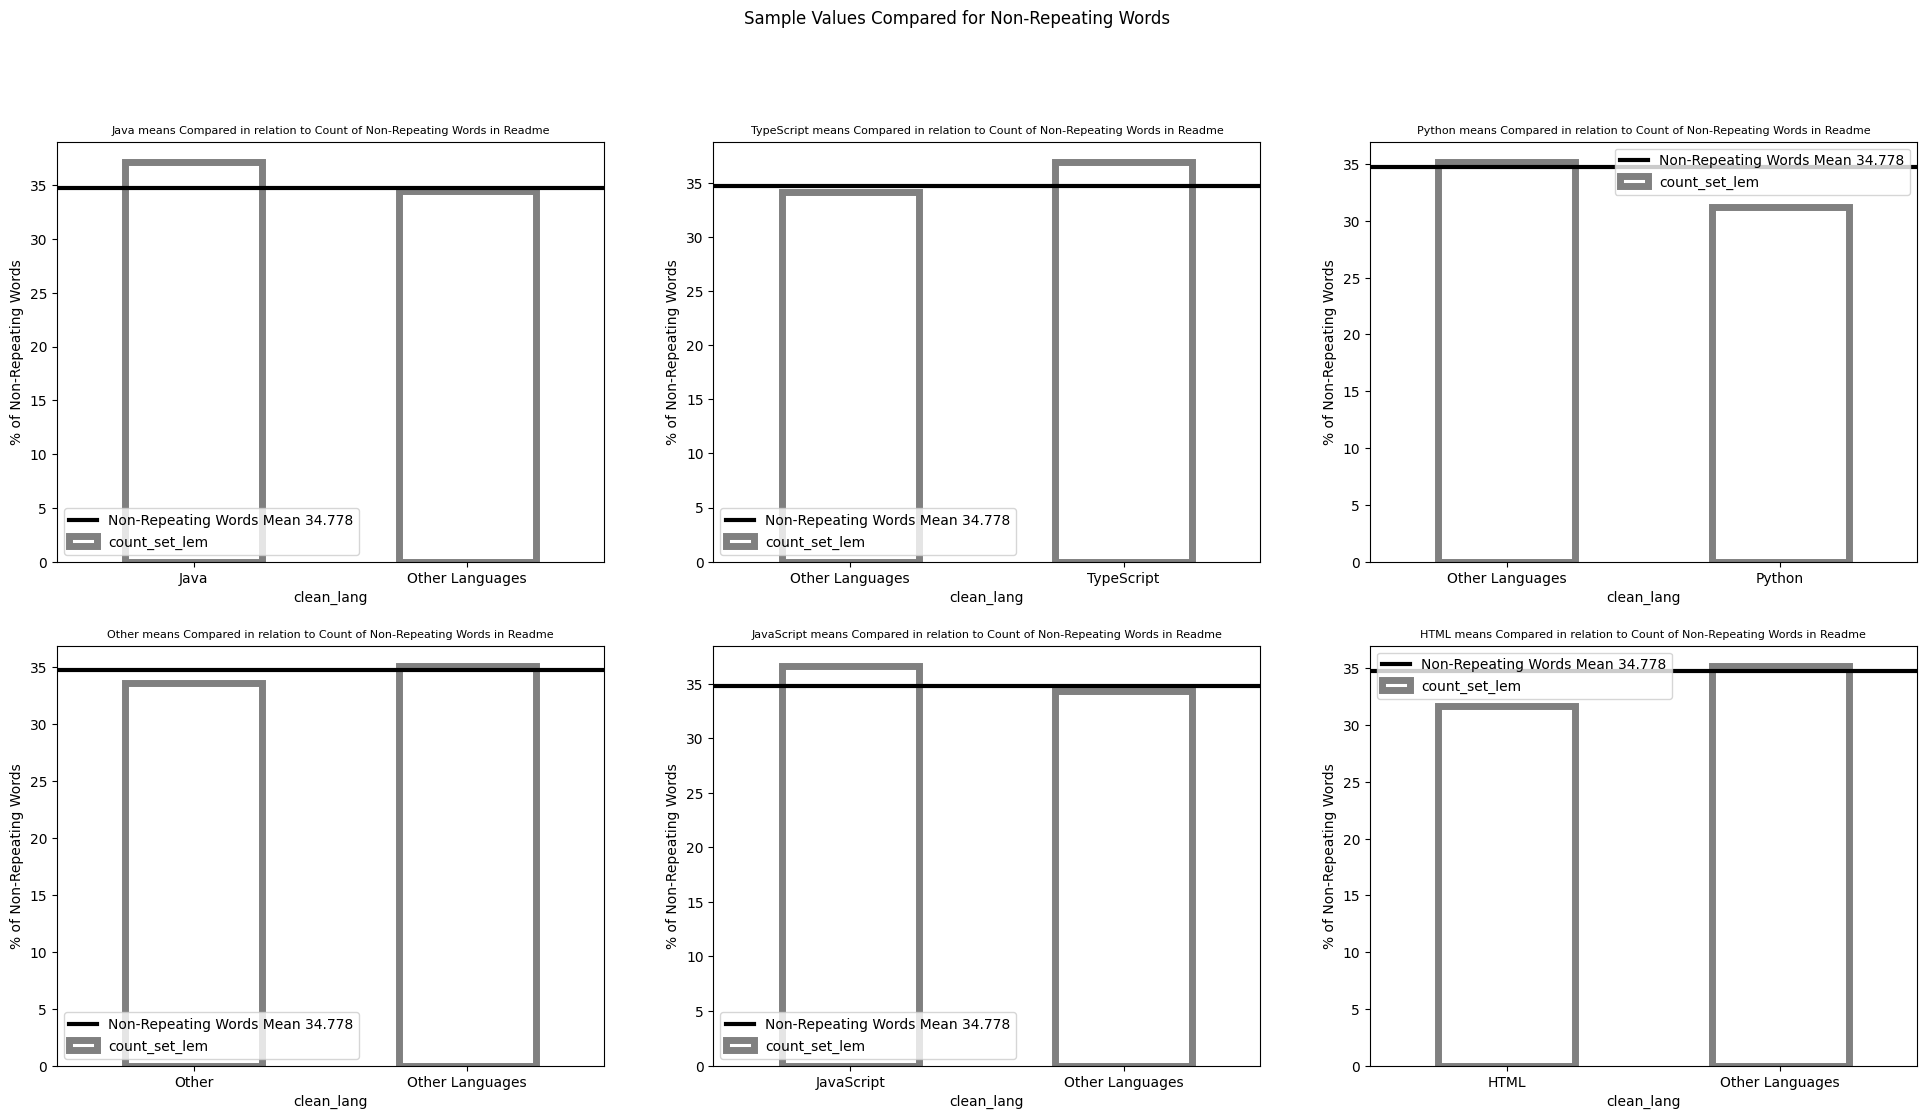

The ones that are similar in value -> ('Python', 'Other', 'HTML') 
The ones not similar in value -> ('Java', 'TypeScript', 'JavaScript')


In [536]:
explore_ttest_lang_setcount(df)

### Takeaways:
- The languages of Python, Other, and HTML share similar values in their word count set "uniqueness"
    - This is not a good feature to use to determine Language for these values
- The languages of Java, TypeScript, and JavaScript are unique in their word count set "uniqueness"
    - This is a good feature to use to determine Language for these values  
    
*`This feature is not the answer by itself and will need addtional features to help determine Language, however it is not completly worthless and we will be considering it's use in modeling.`*

In [568]:
lang

,Language,Words,most_common,count_set_words
0,Java,"[spring, boot, imagehttpscispringioapiv1teamss...","[spring, elasticsearch, dubbo, boot, &#9;]",1235
1,TypeScript,"[p, aligncenter, hrefhttpsantdesign, img, widt...","[de, el, la, un, en]",2332
2,Python,"[englishreadmemd, readmejamd, readmezhhansmd, ...","[python, library, framework, p, tool]",3308
3,Other,"[bitcoin, core, integrationstaging, tree, http...","[redis, httpslabuladonggithubioarticlefnamehtm...",2179
4,JavaScript,"[threejs, npm, packagenpmnpmurl, build, sizebu...","[string, code, build, npm, project]",1688
5,HTML,"[learningarea, github, repo, mdn, learning, ar...","[style, theme, branch, project, mistake]",1085



hypothesis 2
does the most common words vary by language

hypothesis 3
does the length of the repo readme (word amount) vary by language

hypothesis 4
is the most common words in a readme related to the top 95% of words most common to a language for a majority (boolean class)

hypo5